Se importan las siguiente librerías:
- pandas: para poder cargar el dataset
- numpy: para poder manipular los arreglos y usar vectorización
- matplotlib: para graficar
- sklearn: para poder usar el label encoding, estandarizar, one-hot encoding y calcular las métricas

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from scipy.special import softmax

Se cargan los datos del dataset.

In [22]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Función para dividir el datasaet en subconjuntos.

In [23]:
def validate(partitions: tuple[int, ...], X = np.array, Y = np.array):
  assert type(partitions) == tuple, 'Partitions must be a tuple of ints'
  assert sum(partitions) == 100, 'Sum of paritions must be 100'
  assert type(X) == np.ndarray, 'X must be a NDArray'
  assert type(Y) == np.ndarray, 'X must be a NDArray'
  assert X.shape[0] == Y.shape[0], f'X and Y must have the same dimension'

def split_sequencial (partitions: tuple[int, ...], X = np.array, Y = np.array):
  validate(partitions, X, Y)

  length = X.shape[0]
  start_index = 0
  for partition in partitions:
    step = round(partition / 100 * length)
    end_index = start_index + step
    yield X[start_index:end_index]
    yield Y[start_index:end_index]
    start_index = end_index
    start_index = end_index

Se obtienen las X de forma individual y después se apilan en una sola matriz la cuál se estandariza. Finalmente el conjunto se divide en subconjuntos de entrenamiento y prueba.

In [24]:
X1 = df['age'].values
X2 = df['sex'].values
X3 = df['cp'].values
X4 = df['trtbps'].values
X5 = df['chol'].values
X6 = df['fbs'].values
X7 = df['restecg'].values
X8 = df['thalachh'].values
X9 = df['exng'].values
X10 = df['oldpeak'].values
X11 = df['slp'].values
X12 = df['caa'].values
X13 = df['thall'].values
Y = df['output'].values
X = np.column_stack((X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13))
ss = StandardScaler()
X = ss.fit_transform(X)
X_train, Y_train, X_test, Y_test = split_sequencial((80, 20), X, Y)

Se define la clase para la regresión logistica multiclase. Similar a la regresión lineal, salvo que al producto obtenido mediante multiplicar X por los coeficientes (pendiente e intersección) se le aplica la función sigmoide.

In [25]:
onehot_encoder = OneHotEncoder(sparse_output=False)

def loss(X, Y, W):
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
    return loss

def gradient(X, Y, W, mu):
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    return 1/N * (X.T @ (Y - P)) + 2 * mu * W

class MulticlassLR:
    def __init__(self, iters=100, lr=0.001, mu=0.01):
        self.iters = iters
        self.lr = lr
        self.coefficients = None
        self.losses = []
        self.mu = mu

    def fit(self, X, Y):
        Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
        X = np.column_stack([np.ones(X.shape[0]), X])
        self.coefficients = np.zeros((X.shape[1], Y_onehot.shape[1]))
        m = X.shape[0]

        for _ in range(self.iters):
            grad = gradient(X, Y_onehot, self.coefficients, self.mu)
            self.coefficients -= self.lr * grad
            self.losses.append(loss(X, Y_onehot, self.coefficients))

    def predict(self, X):
        X = np.column_stack([np.ones(X.shape[0]), X])
        a = - np.dot(X, self.coefficients)
        return np.argmax(softmax(a, axis=1), axis=1)

Se entrena el modelo

In [26]:
%%time
model = MulticlassLR(200, 0.3)
model.fit(X_train, Y_train)

CPU times: user 18.1 ms, sys: 1.72 ms, total: 19.8 ms
Wall time: 18.7 ms


Se realiza la predicción de los datos de prueba y se obtiene los puntajes con las funciones:
- `accuracy_score`
- `precision_score`
- `f1_score`
- `recall_score` (Sensitivity)

In [29]:
predictions = model.predict(X_test)
print(f'Accuracy score with test dataset: {accuracy_score(Y_test, predictions)}')
print(f'Precision score (Macro) with test dataset: {precision_score(Y_test, predictions, average="macro", zero_division=0)}')
print(f'Precision score (Micro) with test dataset: {precision_score(Y_test, predictions, average="micro", zero_division=0)}')
print(f'Precision score (Weighted) with test dataset: {precision_score(Y_test, predictions, average="weighted", zero_division=0)}')
print(f'F1 score (Macro) with test dataset: {f1_score(Y_test, predictions, average="macro")}')
print(f'F1 score (Micro) with test dataset: {f1_score(Y_test, predictions, average="micro")}')
print(f'F1 score (Weighted) with test dataset: {f1_score(Y_test, predictions, average="weighted")}')
print(f'Sensitivity score (Macro) with test dataset: {recall_score(Y_test, predictions, average="macro", zero_division=0)}')
print(f'Sensitivity score (Micro) with test dataset: {recall_score(Y_test, predictions, average="micro", zero_division=0)}')
print(f'Sensitivity score (Weighted) with test dataset: {recall_score(Y_test, predictions, average="weighted", zero_division=0)}')

Accuracy score with test dataset: 0.6229508196721312
Precision score (Macro) with test dataset: 0.5
Precision score (Micro) with test dataset: 0.6229508196721312
Precision score (Weighted) with test dataset: 1.0
F1 score (Macro) with test dataset: 0.38383838383838387
F1 score (Micro) with test dataset: 0.6229508196721312
F1 score (Weighted) with test dataset: 0.7676767676767677
Sensitivity score (Macro) with test dataset: 0.3114754098360656
Sensitivity score (Micro) with test dataset: 0.6229508196721312
Sensitivity score (Weighted) with test dataset: 0.6229508196721312


Se gráfica la perdida conforme a las iteraciones.

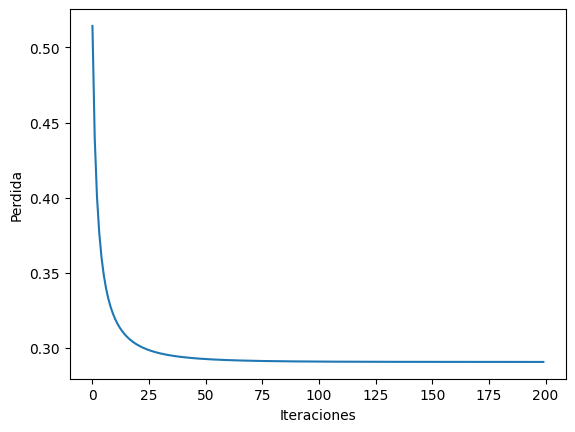

In [30]:
plt.plot(model.losses)
plt.xlabel("Iteraciones")
plt.ylabel("Perdida")
plt.savefig('./MLR-heart-loss.png')
plt.show()